# hitbsec lab

In this notebook we will first examine geo-popularity data by:

* preprocess the data, then
* fit logistic regression model on the data

Then explore geo-popularity data with exponential moving average

* demonstrate the mechanism of exponential moving average
* exploring the ema distributions between benign/mal datasets
* fit logistic regression model using geo-popularity-ema

And lastly dive into a convolutional neural network architecture:

* defining convolution layers, max pooling, dense layers
* defining the learning optimizer and dropout probabilities, to prevent overfitting

We then explore the accuracy of this model:

* looking at the ROC curve

And lastly, we return to the original data:

* exploring the ema distributions between benign/mal datasets


In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import numpy
numpy.random.seed(42)

In [2]:
COUNTRIES = ['A1', 'A2', 'AD', 'AE', 'AF', 'AG', 'AI', 'AL', 'AM', 'AO', 'AP', 'AR', 'AS', 'AT', 'AU', 'AW', 'AX', 'AZ', 'BA', 'BB', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BM', 'BN', 'BO', 'BQ', 'BR', 'BS', 'BT', 'BW', 'BY', 'BZ', 'CA', 'CD', 'CG', 'CH', 'CI', 'CK', 'CL', 'CM', 'CN', 'CO', 'CR', 'CU', 'CV', 'CW', 'CY', 'CZ', 'DE', 'DJ', 'DK', 'DM', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ER', 'ES', 'ET', 'EU', 'FI', 'FJ', 'FK', 'FM', 'FO', 'FR', 'GA', 'GB', 'GD', 'GE', 'GF', 'GG', 'GH', 'GI', 'GL', 'GM', 'GN', 'GP', 'GQ', 'GR', 'GT', 'GU', 'GW', 'GY', 'HK', 'HN', 'HR', 'HT', 'HU', 'ID', 'IE', 'IL', 'IM', 'IN', 'IQ', 'IR', 'IS', 'IT', 'JE', 'JM', 'JO', 'JP', 'KE', 'KG', 'KH', 'KM', 'KN', 'KP', 'KR', 'KW', 'KY', 'KZ', 'LA', 'LB', 'LC', 'LI', 'LK', 'LR', 'LS', 'LT', 'LU', 'LV', 'LY', 'MA', 'MC', 'MD', 'ME', 'MF', 'MG', 'MH', 'MK', 'ML', 'MM', 'MN', 'MO', 'MP', 'MQ', 'MR', 'MT', 'MU', 'MV', 'MW', 'MX', 'MY', 'MZ', 'NA', 'NC', 'NE', 'NG', 'NI', 'NL', 'NO', 'NP', 'NU', 'NZ', 'OM', 'PA', 'PE', 'PF', 'PG', 'PH', 'PK', 'PL', 'PR', 'PS', 'PT', 'PW', 'PY', 'QA', 'RE', 'RO', 'RS', 'RU', 'RW', 'SA', 'SB', 'SC', 'SD', 'SE', 'SG', 'SI', 'SK', 'SL', 'SM', 'SN', 'SO', 'SR', 'ST', 'SV', 'SX', 'SY', 'SZ', 'TC', 'TD', 'TG', 'TH', 'TJ', 'TL', 'TM', 'TN', 'TO', 'TR', 'TT', 'TW', 'TZ', 'UA', 'UG', 'US', 'UY', 'UZ', 'VA', 'VC', 'VE', 'VG', 'VI', 'VN', 'VU', 'WS', 'YE', 'YT', 'ZA', 'ZM', 'ZW']

# Section 1: Geo-popularity data exploration

### data loading
Prior to the lab we gathered and labeled EMA data. So we simply load the benign (ben) & malicious (mal) datasets.

In [3]:
# load dataset
with open('data/unk', 'r') as f:
    ben_raw = f.readlines()

with open('data/mal', 'r') as f:
    mal_raw = f.readlines()

### data peak
Geo popularity data consists of domain name, country code and visit count pairs
    * [domain, "COUNTRY,val",....]

In [4]:
print(mal_raw[0])
print(mal_raw[0].strip().split(':'))

uquklrxvq.com:EG,3.0:MY,4.0:PK,3.0:NG,15.0:GT,3.0:IR,2.0:AR,7.0:ID,13.0

['uquklrxvq.com', 'EG,3.0', 'MY,4.0', 'PK,3.0', 'NG,15.0', 'GT,3.0', 'IR,2.0', 'AR,7.0', 'ID,13.0']


### convert data into dense vector for classification

In [5]:
# parse raw lines into dense vector
def parse(line):
    parts = [p.split(',') for p in line.strip().split(':')[1:]]
    country_map = {p[0]: float(p[1]) for p in parts}
    country_vec = numpy.array([country_map[c] if c in country_map else 0.0 for c in COUNTRIES])
    return country_vec

In [6]:
parse(mal_raw[0])

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,  13.,   0.,   0.,   0.,
         0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   4.,   

### data preprocess
* Convert benigh and malicious data into dense vector
* Label benigh as `0` and malicious as `1`
* Shuffle dataset and split data into training and testing

In [7]:
def preprocess(data):
    return numpy.array([parse(line) for line in data])

In [8]:
ben_x = preprocess(ben_raw)
ben_y = numpy.full(len(ben_x), 0)
mal_x = preprocess(mal_raw)
mal_y = numpy.full(len(mal_x), 1)

In [9]:
def split(x, y):
    permutation = numpy.random.permutation(len(x)).tolist()
    split = int(len(x) * 0.7)

    x_train, x_test = x[permutation[:split]], x[permutation[split:]]
    y_train, y_test = y[permutation[:split]], y[permutation[split:]]
    return x_train, y_train, x_test, y_test

In [10]:
x = numpy.concatenate((ben_x, mal_x), axis=0)
y = numpy.concatenate((ben_y, mal_y), axis=0)
x_train, y_train, x_test, y_test = split(x, y)

### fit logistic regression on geo-popularity data

In [11]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### model evaluation

In [12]:
from sklearn import metrics
y_hat = lgr.predict(x_test)
print(metrics.classification_report(y_test, y_hat, target_names=['benign', 'malware']))

             precision    recall  f1-score   support

     benign       0.57      0.90      0.70      1446
    malware       0.80      0.37      0.51      1554

avg / total       0.69      0.63      0.60      3000



#### roc

But overall accuracy is sometimes misleading. We therefore use the receiver operator curve (`ROC`) to show the tradeoff between our models:
* false positive
* true positive

In effect, we want a high accuracy with low false positive: e.g. we want a curve pinned to the upper left-hand corner.

See [Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for more information

In [13]:
def plot_roc(y, y_pred):
    acc = metrics.roc_auc_score(y, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred)
    plt.title("AUC= %f" % acc)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [14]:
# predict class probability by calling `predict_proba` method
y_hat_proba = lgr.predict_proba(x_test)
y_hat_proba

array([[ 0.53438405,  0.46561595],
       [ 0.53960422,  0.46039578],
       [ 0.51157389,  0.48842611],
       ..., 
       [ 0.55606112,  0.44393888],
       [ 0.61036963,  0.38963037],
       [ 0.39967877,  0.60032123]])

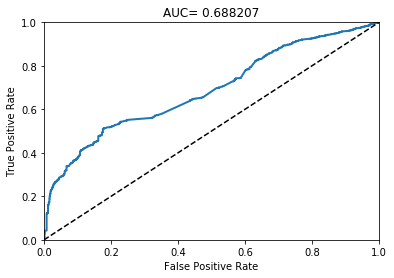

In [15]:
plot_roc(y_test, y_hat_proba[:,1])

#### examine model coefficient

In [16]:
sorted(zip(COUNTRIES, lgr.coef_.tolist()[0]), key=lambda x: x[1])

[('NL', -0.0505448805669427),
 ('AU', -0.03262437133784673),
 ('DZ', -0.025187681237113506),
 ('DE', -0.024287469126064207),
 ('BG', -0.023879971015877),
 ('AF', -0.023422285675417875),
 ('SA', -0.023103499558056698),
 ('AR', -0.020645799624279534),
 ('NI', -0.01653371953586121),
 ('SK', -0.01650657103162928),
 ('SE', -0.015830052159004574),
 ('JO', -0.015238865974280558),
 ('BE', -0.014032863413790878),
 ('DK', -0.013664363395601667),
 ('ES', -0.013017216522416681),
 ('GR', -0.013016184426445122),
 ('NO', -0.01291644880984468),
 ('MA', -0.011217128751721074),
 ('AM', -0.010576540938472078),
 ('ZA', -0.009800967549231017),
 ('EU', -0.009168209547758828),
 ('PK', -0.008409341097879617),
 ('BY', -0.0077179901852228215),
 ('SG', -0.007408915749538728),
 ('LB', -0.00736491558360098),
 ('IL', -0.007190594835639875),
 ('SI', -0.007182042878111451),
 ('AL', -0.007008970210916792),
 ('IQ', -0.006477601978528061),
 ('BD', -0.0062092017355252875),
 ('US', -0.005683043298216375),
 ('CL', -0.00531

# Section 2: Geo-popularity Exponential Moving Average

### demo of exponential moving average

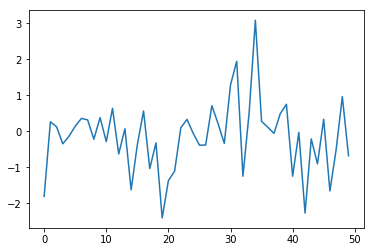

In [17]:
ts = numpy.random.randn(50)
plt.plot(range(len(ts)), ts)

In [18]:
def ema(curr, previous, alpha):
    return curr * alpha + previous * (1 - alpha)

In [19]:
emas = []
prev = 0
for n in ts:
    prev = ema(n, prev, 0.25)
    emas.append(prev)

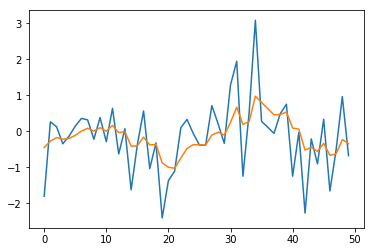

In [20]:
plt.plot(range(len(ts)), ts)
plt.plot(range(len(ts)), emas)

In [21]:
def plot_ema(ts, alpha):
    '''
    Compute emas for x and list of alphas, and plot them
    '''
    plt.figure(figsize=(20,10))
    plt.plot(range(len(ts)), ts, label="raw")
    for a in alpha:
        vals = []
        prev = 0.0
        for n in ts:
            prev = n * a + prev * (1.0 - a)
            vals.append(prev)
        plt.plot(range(len(ts)), vals, label="alpha=%.2f" % a)
    plt.legend()
    plt.show()

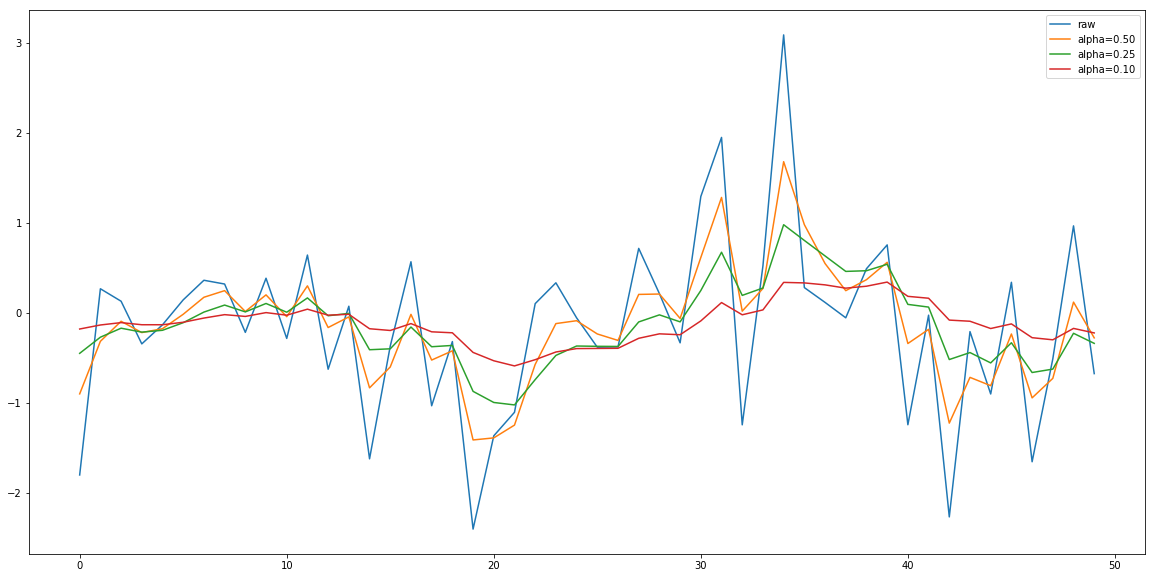

In [22]:
plot_ema(ts.tolist(), [0.5, 0.25, 0.1])

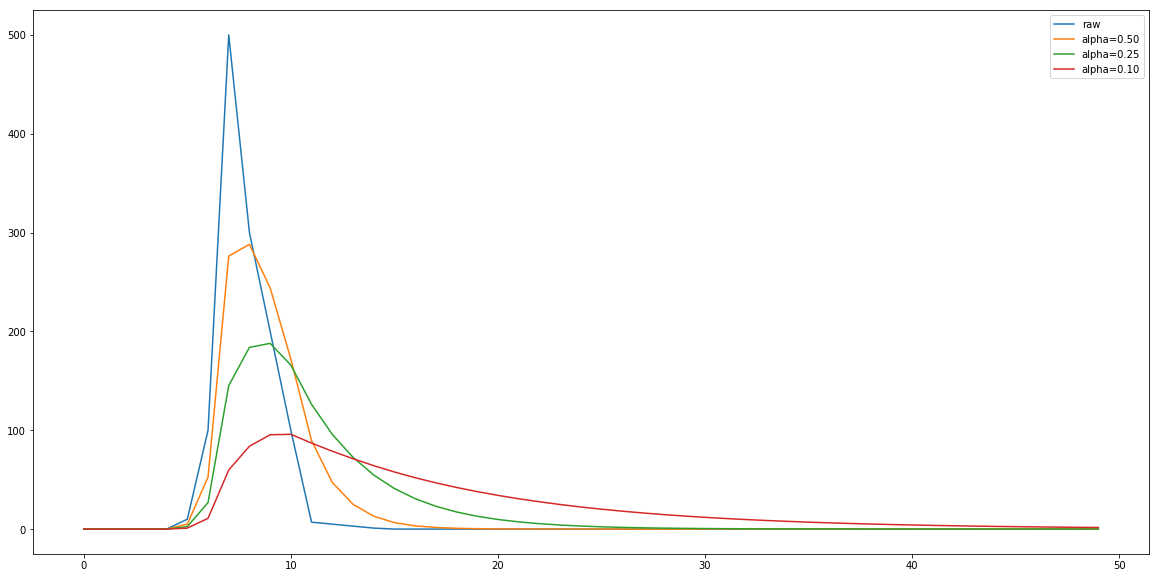

In [23]:
ts2 = [0] * 50
ts2[5:15] = [10, 100, 500, 300, 200, 100, 7, 5, 3, 1]
plot_ema(ts2, [0.5, 0.25, 0.1])

### data peek

Geo popularity ema data consists of domain name and country emas in the following format:
    * [domain, "COUNTRY,current,ema1,ema2,max",....]

In [24]:
# load exponential moving average dataset
with open('data/unk_ema', 'r') as f:
    ben_ema_raw = f.readlines()

with open('data/mal_ema', 'r') as f:
    mal_ema_raw = f.readlines()

In [25]:
# examine data format
print(mal_ema_raw[0])
ben_ema_raw[0].split(':')

dqnlfkh.net:RU,0.0,0.005637710113660432,0.060037854118799694,4.0:UA,0.0,0.002818855056830216,0.030018927059399847,2.0:DZ,0.0,0.005637710113660432,0.060037854118799694,4.0:IN,0.0,0.02114141292622662,0.2251419529454988,15.0:VN,0.0,0.012684847755735973,0.13508517176729928,9.0:EC,0.0,0.002818855056830216,0.030018927059399847,2.0:TR,0.0,0.02959797809671727,0.3151987341236983,21.0:PH,0.0,0.004228282585245324,0.04502839058909977,3.0:US,0.0,0.0070471376420755405,0.0750473176484996,5.0:IT,0.0,0.004228282585245324,0.04502839058909977,3.0:BR,0.0,0.02114141292622662,0.2251419529454988,15.0:NL,0.0,0.002818855056830216,0.030018927059399847,2.0:BG,0.0,0.011275420227320865,0.12007570823759939,8.0:NG,0.0,0.07188080394917051,0.7654826400146961,51.0:ID,0.0,0.09302221687539713,0.9906245929601946,66.0



['frazierallen.com',
 'UA,0.0,0.0013378550367377784,0.02954312706550836,3.0',
 'US,0.0,0.4270360133967017,0.3709732413895943,4.0',
 'CH,0.0,0.0026757100734755568,0.05908625413101672,6.0',
 'RU,0.0,0.004013565110213335,0.08862938119652508,9.0',
 'CA,0.0,0.75,0.30000000000000004,3.0\n']

### data exploration

In [26]:
def plot_ben_vs_mal_ema(feature_func, val_range, bins):
    ben_val = [feature_func(l) for l in ben_ema_raw]
    mal_val = [feature_func(l) for l in mal_ema_raw]

    fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
    ax1, ax2 = axes.flatten()

    ax1.hist(ben_val, range=val_range, bins=bins)
    ax2.hist(mal_val, range=val_range, bins=bins)
    ax1.set_xlabel('Bucket Value')
    ax1.set_ylabel('Count')
    ax1.set_title('Benign')
    ax2.set_xlabel('Bucket Value')
    ax2.set_ylabel('Count')
    ax2.set_title('Malicious')
    plt.show()

#### number of countries by category

First we check to see if the number of unique countries requesting a `domain` differ between the `ben` and `mal` class.

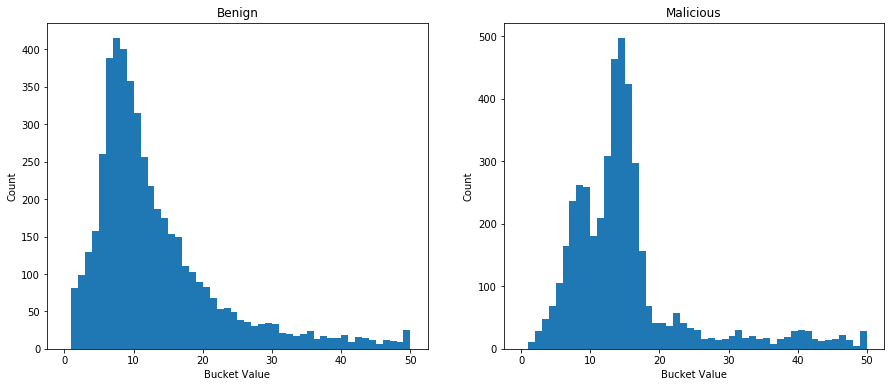

In [27]:
def get_country_count(l):
    '''
    For each domain, return the number of countries we've seen traffic from
    '''
    return len([p for p in l.strip().split(":")[1:] if p])

plot_ben_vs_mal_ema(get_country_count, (0, 50), 50)

#### peek number of requests

Lastly, we check to see if the max number of clients per `domain` differ between the `ben` and `mal` class. We approximate the maximun number by sum up the max values from each country.

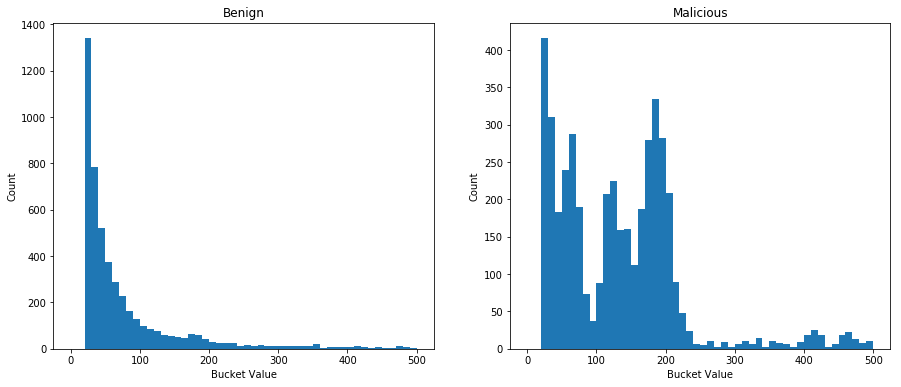

In [28]:
def get_sum_of_max(l):
    '''
    For each domain, return the sum of the max values
    '''
    maximums = [float(p.split(',')[-1]) for p in l.strip().split(":")[1:] if p]
    return sum(maximums) if maximums else 0
plot_ben_vs_mal_ema(get_sum_of_max, (0, 500), 50)

### data preprocess
* Convert benigh and malicious ema data into dense vector
* Label benigh as `0` and malicious as `1`
* Shuffle dataset and split data into training and testing

In [29]:
empty = numpy.array([0, 0, 0, 0])
def parse_ema(line, countries):
    parts = line.strip().split(":")
    country_data = [p.split(",") for p in parts[1:]]
    country_map = {d[0] : numpy.array([float(f) for f in d[1:]]) for d in country_data}
    m = numpy.array([country_map[c] if c in country_map else empty for c in countries])
    return m.transpose()

In [30]:
parse_ema(ben_ema_raw[0], COUNTRIES).shape

(4, 229)

In [31]:
parse_ema(ben_ema_raw[0], COUNTRIES)

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

In [32]:
def preprocess_ema(ema_data):
    return numpy.array([parse_ema(l, COUNTRIES) for l in ema_data])

In [33]:
# preprocess ema data
ben_x2 = preprocess_ema(ben_ema_raw)
ben_y2 = numpy.full(len(ben_x2), 0)
mal_x2 = preprocess_ema(mal_ema_raw)
mal_y2 = numpy.full(len(mal_x2), 1)

# concanate
x2 = numpy.concatenate((ben_x2, mal_x2), axis=0)
y2 = numpy.concatenate((ben_y2, mal_y2), axis=0)

In [34]:
print(x2.shape)
# reshape each x into 1D vectors
x2 = x2.reshape(x2.shape[0], x2.shape[1] * x2.shape[2])
print(x2.shape)

(10000, 4, 229)
(10000, 916)


In [35]:
x_train2, y_train2, x_test2, y_test2 = split(x2, y2)

### retrain linear mode with ema data

In [36]:
lgr_ema = LogisticRegression()
lgr_ema.fit(x_train2, y_train2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### model evaluation

In [37]:
y_hat2 = lgr_ema.predict(x_test2)
metrics.accuracy_score(y_test2, y_hat2)

0.84333333333333338

/Users/jingcche/workspace/python-envs/default/lib/python2.7/site-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


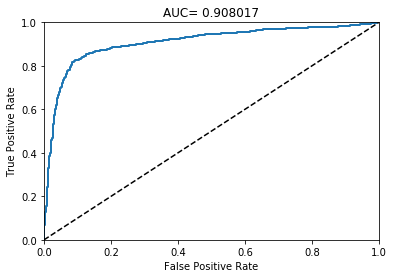

In [38]:
# ROC
y_hat_proba2 = lgr_ema.predict_proba(x_test2)
plot_roc(y_test2, y_hat_proba2[:,1])

In [39]:
keys = [c + suff for suff in ['_curr', '_ema1', '_ema2', '_max'] for c in COUNTRIES]
sorted(zip(keys, lgr_ema.coef_.tolist()[0]), key=lambda x: x[1])

[('CN_max', -0.036639385306114665),
 ('NL_max', -0.025790896779818495),
 ('US_ema1', -0.016492925252498708),
 ('DK_max', -0.015078497275031072),
 ('ID_ema1', -0.010825055462712216),
 ('AU_max', -0.010566890418466656),
 ('US_ema2', -0.009470863006977411),
 ('FR_max', -0.008312323698480067),
 ('ID_ema2', -0.008088532985369146),
 ('PL_max', -0.007180746451414422),
 ('TR_ema2', -0.006462163891186704),
 ('SE_max', -0.005737963494387894),
 ('ID_curr', -0.005623370712363079),
 ('TR_ema1', -0.005041494090316087),
 ('TW_max', -0.004480161611066927),
 ('GB_ema1', -0.004440926738526688),
 ('KR_max', -0.004194720833949253),
 ('ES_max', -0.004115642052079907),
 ('VN_ema2', -0.004050954819717061),
 ('CA_ema1', -0.003984815728271248),
 ('GB_ema2', -0.0039038743394140506),
 ('IL_max', -0.003615301520088597),
 ('CA_ema2', -0.0034632665214362245),
 ('EU_max', -0.0032868004190966496),
 ('RO_max', -0.0032710204630114685),
 ('VN_ema1', -0.003156448410607432),
 ('DZ_max', -0.002976585758173656),
 ('BE_max',

# Section 3: Convolutional Neural Networks for Geo-Popularity

### data preprocess
* Reuse the same parsing function in previous section with some reshaping
* For each y, tensorflow needs 1 * 2 Matrix instead of Scalar

In [40]:
ben_x3 = preprocess_ema(ben_ema_raw)
ben_y3 = numpy.array([1, 0]).reshape(1, 2).repeat(len(ben_ema_raw), axis=0)
mal_x3 = preprocess_ema(mal_ema_raw)
mal_y3 = numpy.array([0, 1]).reshape(1, 2).repeat(len(mal_ema_raw), axis=0)

x3 = numpy.concatenate((ben_x3, mal_x3), axis=0)
# reshape x to meet requirement of keras
x3 = x3.reshape(x3.shape[0], x3.shape[1], x3.shape[2], 1)
y3 = numpy.concatenate((ben_y3, mal_y3), axis=0)

x_train3, y_train3, x_test3, y_test3 = split(x3, y3)

### define CNN Architecture

Here we define a simple cnn neural network architecture:
    * input layer
    * 2d convolution layer
    * 2d max pooling layer
    * dense layer
    * dropout 
    
Then we define the `loss` function and method to update the weights in the backpropagation step:
    * categorical cross entropy
    *  Kingma and Ba's Adam algorithm (updating moving averages of the parameters)

In [41]:
import keras
from keras import Input
from keras.engine import Model
from keras.models import Sequential, load_model
from keras.layers import Embedding, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Dense, Dropout, concatenate, Activation
from keras.callbacks import TensorBoard

def convolution_model_hierarchy(width, length):

    model = Sequential()
    model.add(Conv2D(length, (3,3), padding='same',
                     input_shape=(width, length, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Conv2D(length, (3,3)))
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

tb_callback=TensorBoard(log_dir="tensorboard",
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

model = convolution_model_hierarchy(x3.shape[1], x3.shape[2])

Using TensorFlow backend.


### model.fit

We then test our architecture on only two epochs. We typically see accuracy at `0.85` or greater in the intiial run.

In [42]:
model.fit(x_train3, y_train3,
          batch_size=100, epochs=2,
          verbose=1,
          callbacks=[tb_callback])

Epoch 1/2
7000/7000 [==============================] - 41s - loss: 0.7867 - acc: 0.8539    
Epoch 2/2
7000/7000 [==============================] - 41s - loss: 0.4009 - acc: 0.8877    


### model.evaluate

We evaluate the trained model on our `x_test` dataset. Simply calling `model.evaluate` does the trick.

In [43]:
for name, val in zip(model.metrics_names, model.evaluate(x_test3, y_test3)):
    print("%s: %f" % (name, val))

3000/3000 [==============================] - 4s     
loss: 0.365547
acc: 0.888333


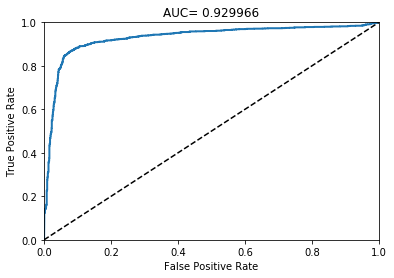

In [44]:
y_hat3 = model.predict(x_test3)
plot_roc(y_test3[:,1], y_hat3[:,1])

comparison of triditional models and deep network: [Link](https://lilianweng.github.io/lil-log/2017/06/21/an-overview-of-deep-learning.html)